# Cádiz

## Load libraries needed 

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns
import math
from datetime import date, timedelta
from pandas import read_csv
from pandas.plotting import register_matplotlib_converters
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler 

## Load "Total" dataset

In [2]:
df_total = pd.read_excel('Total.xls')
# Edit columns names + Lower case column names
df_total.columns = map(str.lower, df_total.columns)
df_total.columns

Index(['sub_region_2', 'fecha', 'provincia_iso', 'num_casos.x',
       'num_casos_prueba_pcr', 'num_casos_prueba_test_ac',
       'num_casos_prueba_ag', 'num_casos_prueba_elisa',
       'num_casos_prueba_desconocida', 'num_casos.y', 'num_hosp', 'num_uci',
       'num_def', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'total'],
      dtype='object')

## Dataframe under observation

In [3]:
Cad=df_total.loc[df_total['sub_region_2'] == 'Cádiz']

In [4]:
# Set index 
Cad = Cad.set_index('fecha')

In [5]:
# We select columns of interest (mobility ones)
Cad=Cad[['num_casos.x'] + list(Cad.loc[:,'retail_and_recreation_percent_change_from_baseline':'total'])]

## Plots

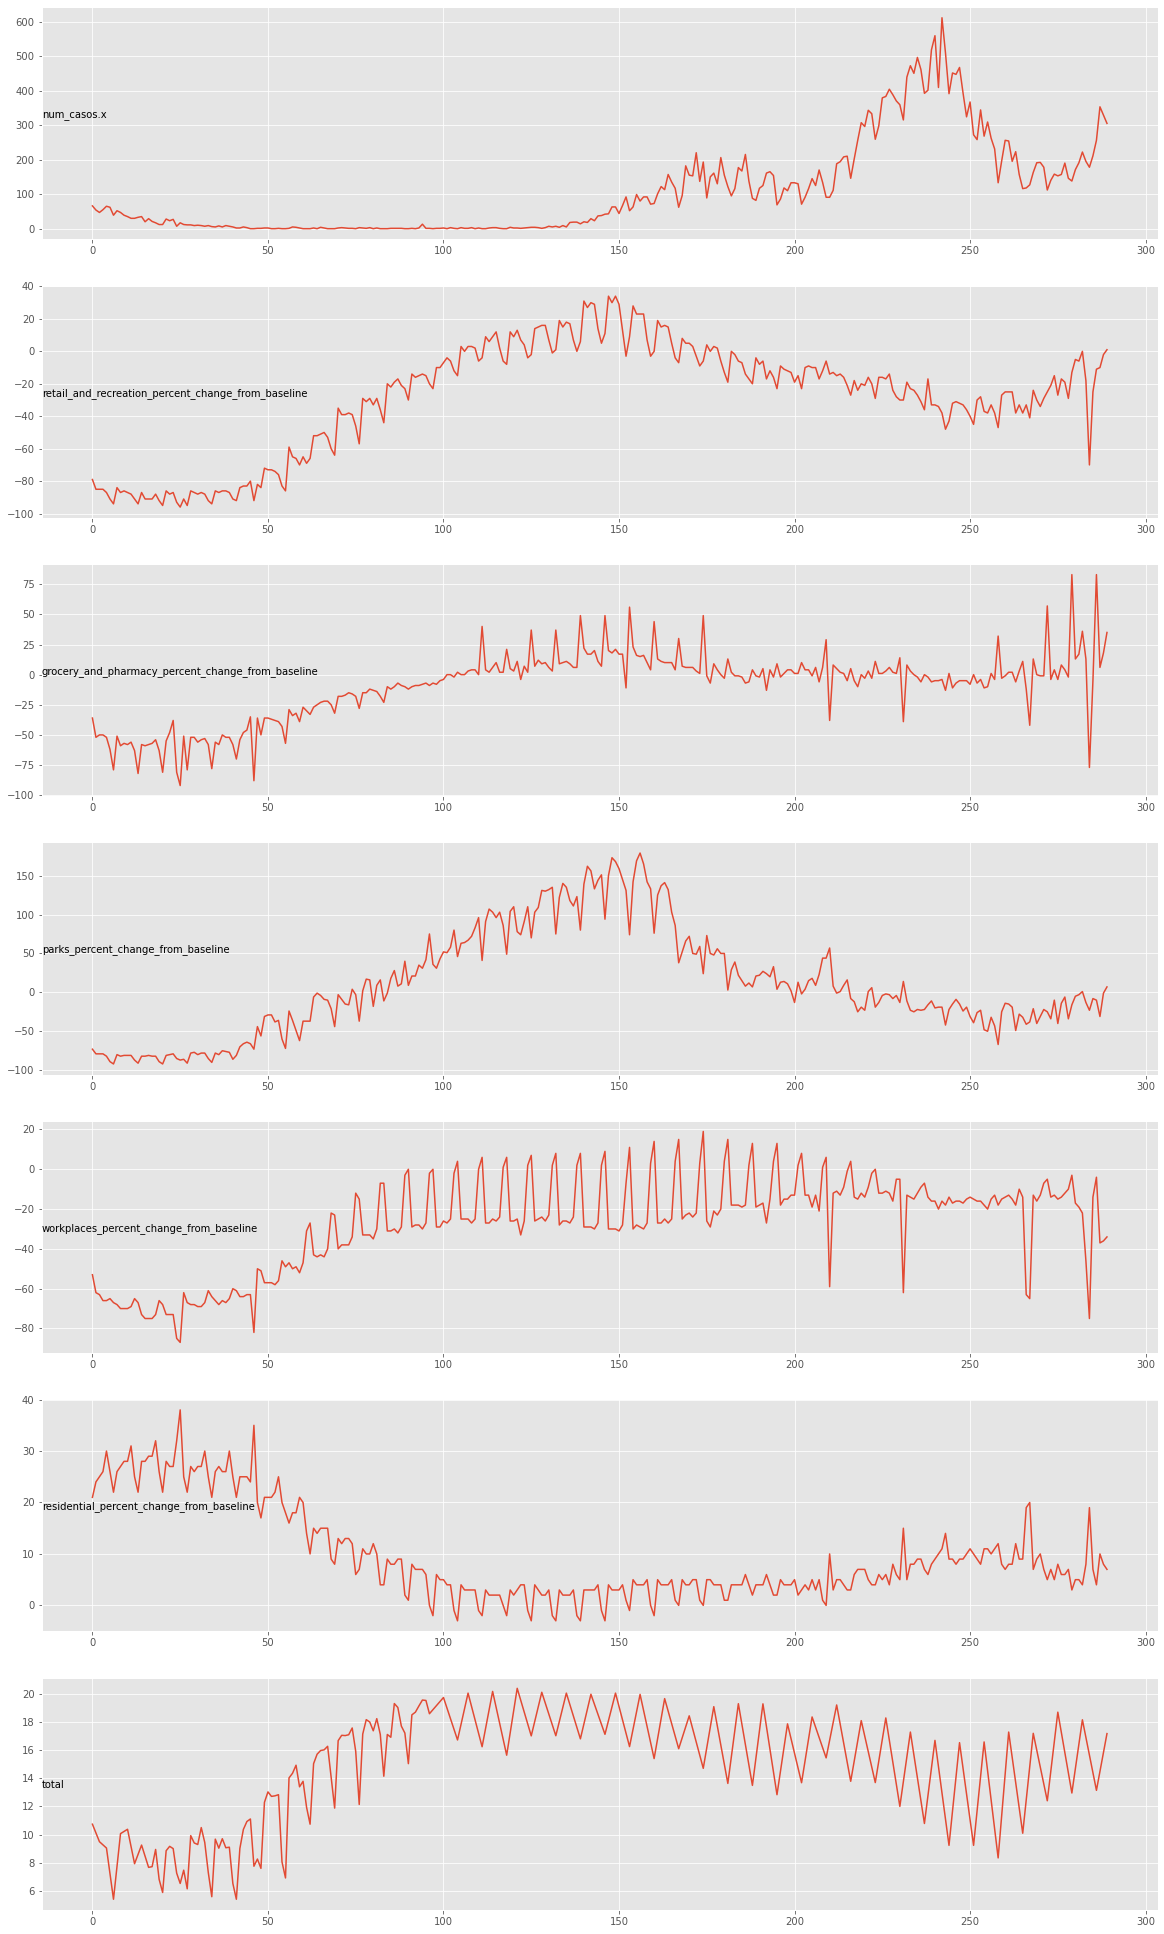

In [6]:
# Columns to plot (mobility ones)
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure(figsize=(20,35))
for group in groups:
    plt.subplot(len(groups), 1, i)    
    ## Change "Bar" by any other region for the other cases ##
    plt.plot(Cad.values[:, group])     
    plt.title(Cad.columns[group], y=0.5, fontsize=10, loc='left')
    i += 1
plt.show()

## LSTM - Univariate

In [7]:
# New dataframe with only the 'num_casos.x' column 
# Convert it to numpy array
data = Cad.filter(['num_casos.x'])
npdataset = data.values

# Get the number of rows to train the model
# 94% of the data in order to have the same scenario like in ARIMA 
# Train 273 - Test 17
training_data_length = math.ceil(len(npdataset) * 0.94)

# Transform features by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(npdataset)
scaled_data[0:5]

array([[0.10801964],
       [0.08837971],
       [0.07692308],
       [0.09001637],
       [0.10638298]])

In [8]:
npdataset[0:5]

array([[66],
       [54],
       [47],
       [55],
       [65]], dtype=int64)

In [9]:
len(scaled_data)

290

In [10]:
training_data_length

273

In [11]:
# We create the scaled training data set
train_data = scaled_data[0:training_data_length, :]
# Nº of previous days check for forecast                                                      
loop_back = 14

# BS - 5
#MAE: 377.5
#RMSE: 103.3

# BS - 2
#MAE: 275.1 / 281.4 / 275.1 
#RMSE: 64.7 / 98.3 / 76.3

# BS - 1
#MAE: 275.6
#RMSE: 111.7

In [12]:
# Split the data into x_train and y_train data sets
# We create a supervised "problem"
x_train = []
y_train = []
trainingdatasize = len(train_data) 
for i in range(loop_back, trainingdatasize):
    #print(i)
    #contains loop_back values 0-loop_back
    x_train.append(train_data[i-loop_back: i, 0])    
    #contains all other values 
    y_train.append(train_data[i, 0])    

In [13]:
# list
x_train[0:2]

[array([0.10801964, 0.08837971, 0.07692308, 0.09001637, 0.10638298,
        0.101473  , 0.06382979, 0.08510638, 0.07692308, 0.06382979,
        0.05728314, 0.04909984, 0.04909984, 0.05400982]),
 array([0.08837971, 0.07692308, 0.09001637, 0.10638298, 0.101473  ,
        0.06382979, 0.08510638, 0.07692308, 0.06382979, 0.05728314,
        0.04909984, 0.04909984, 0.05400982, 0.05728314])]

In [14]:
# list
y_train[0:2]

[0.05728314238952537, 0.03273322422258593]

In [15]:
# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train[0:2])
print("-----------------------------------------------------------")
print(y_train[0:2])

[[0.10801964 0.08837971 0.07692308 0.09001637 0.10638298 0.101473
  0.06382979 0.08510638 0.07692308 0.06382979 0.05728314 0.04909984
  0.04909984 0.05400982]
 [0.08837971 0.07692308 0.09001637 0.10638298 0.101473   0.06382979
  0.08510638 0.07692308 0.06382979 0.05728314 0.04909984 0.04909984
  0.05400982 0.05728314]]
-----------------------------------------------------------
[0.05728314 0.03273322]


In [16]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

(259, 14, 1)
(259,)


In [17]:
x_train[0:2]

array([[[0.10801964],
        [0.08837971],
        [0.07692308],
        [0.09001637],
        [0.10638298],
        [0.101473  ],
        [0.06382979],
        [0.08510638],
        [0.07692308],
        [0.06382979],
        [0.05728314],
        [0.04909984],
        [0.04909984],
        [0.05400982]],

       [[0.08837971],
        [0.07692308],
        [0.09001637],
        [0.10638298],
        [0.101473  ],
        [0.06382979],
        [0.08510638],
        [0.07692308],
        [0.06382979],
        [0.05728314],
        [0.04909984],
        [0.04909984],
        [0.05400982],
        [0.05728314]]])

In [18]:
y_train[0:2]

array([0.05728314, 0.03273322])

In [19]:
# Create a new array containing scaled test values
test_data = scaled_data[training_data_length - loop_back:, :]
#test_data
#test_data.shape

# Create the data sets x_test and y_test
x_test = []
y_test = []
#y_test = npdataset[training_data_length:, :]
#y_test = scaled_data[training_data_length:, :]
for i in range(loop_back, len(test_data)):
    x_test.append(test_data[i-loop_back:i, 0])
    y_test.append(test_data[i, 0])    

# Convert the data to a numpy array
x_test = np.array(x_test)
y_test = np.array(y_test)

# Reshape the data, so that we get an array with multiple test datasets
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_test[0:2])
print("-----------------------------------------------------------")
print(y_test[0:2])

[[[0.3207856 ]
  [0.41898527]
  [0.41571195]
  [0.31914894]
  [0.36497545]
  [0.25695581]
  [0.1898527 ]
  [0.19312602]
  [0.20785597]
  [0.26677578]
  [0.31260229]
  [0.31423895]
  [0.2913257 ]
  [0.18330606]]

 [[0.41898527]
  [0.41571195]
  [0.31914894]
  [0.36497545]
  [0.25695581]
  [0.1898527 ]
  [0.19312602]
  [0.20785597]
  [0.26677578]
  [0.31260229]
  [0.31423895]
  [0.2913257 ]
  [0.18330606]
  [0.22913257]]]
-----------------------------------------------------------
[0.22913257 0.25859247]


In [20]:
print(x_test.shape)
print(y_test.shape)

(17, 14, 1)
(17,)



As stated by **Brownlee (2018)**... "

**Stochastic Gradient Descent**

* Stochastic Gradient Descent, or SGD for short, is an optimization algorithm used to train machine learning algorithms, most notably artificial neural networks used in deep learning.

* The job of the algorithm is to find a set of internal model parameters that perform well against some performance measure such as logarithmic loss or mean squared error.

* Optimization is a type of searching process and you can think of this search as learning. The optimization algorithm is called “gradient descent“, where “gradient” refers to the calculation of an error gradient or slope of error and “descent” refers to the moving down along that slope towards some minimum level of error.

* The algorithm is iterative. This means that the search process occurs over multiple discrete steps, each step hopefully slightly improving the model parameters.

* Each step involves using the model with the current set of internal parameters to make predictions on some samples, comparing the predictions to the real expected outcomes, calculating the error, and using the error to update the internal model parameters.

* This update procedure is different for different algorithms, but in the case of artificial neural networks, the backpropagation update algorithm is used.

**What Is a Sample?**

* A sample is a single row of data.

* It contains inputs that are fed into the algorithm and an output that is used to compare to the prediction and calculate an error.

* A training dataset is comprised of many rows of data, e.g. many samples. A sample may also be called an instance, an observation, an input vector, or a feature vector.

* Now that we know what a sample is, let’s define a batch.

**What Is a Batch?**

* The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters.

* Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient.

* A training dataset can be divided into one or more batches.

* When all training samples are used to create one batch, the learning algorithm is called batch gradient descent. When the batch is the size of one sample, the learning algorithm is called stochastic gradient descent. When the batch size is more than one sample and less than the size of the training dataset, the learning algorithm is called mini-batch gradient descent.

    * Batch Gradient Descent. Batch Size = Size of Training Set
    * Stochastic Gradient Descent. Batch Size = 1
    * Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set

**What Is an Epoch?**

* The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.

* One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. For example, as above, an epoch that has one batch is called the batch gradient descent learning algorithm.

* You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples.

* The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. You may see examples of the number of epochs in the literature and in tutorials set to 10, 100, 500, 1000, and larger.

* It is common to create line plots that show epochs along the x-axis as time and the error or skill of the model on the y-axis. These plots are sometimes called learning curves. These plots can help to diagnose whether the model has over learned, under learned, or is suitably fit to the training dataset.

**Worked Example**

* Finally, let’s make this concrete with a small example.

* Assume you have a dataset with 200 samples (rows of data) and you choose a batch size of 5 and 1,000 epochs.

* This means that the dataset will be divided into 40 batches, each with five samples. The model weights will be updated after each batch of five samples.

* This also means that one epoch will involve 40 batches or 40 updates to the model.

* With 1,000 epochs, the model will be exposed to or pass through the whole dataset 1,000 times. That is a total of 40,000 batches during the entire training process.

..."

Brownlee, J., 2018. Difference Between a Batch and an Epoch in a Neural Network. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/> [Accessed 12 May 2021].

In [21]:
# Configure / setup the neural network model - LSTM
model = Sequential()

# Model with Neurons 
# Inputshape = neurons -> Timestamps
neurons= x_train.shape[1]
model.add(LSTM(14, 
               activation='relu',
               return_sequences=True, 
               input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(50, 
               activation='relu',
               return_sequences=True)) 
model.add(LSTM(25, 
               activation='relu',
               return_sequences=False)) 
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
# Training the model
#early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
# fit network
history=model.fit(x_train,
                  y_train,
                  #callbacks=[early_stop],
                  batch_size=2, 
                  epochs=50, 
                  validation_data=(x_test, y_test), 
                  verbose=2)

Epoch 1/50
130/130 - 11s - loss: 0.0224 - val_loss: 0.0163
Epoch 2/50
130/130 - 2s - loss: 0.0110 - val_loss: 0.0120
Epoch 3/50
130/130 - 2s - loss: 0.0087 - val_loss: 0.0093
Epoch 4/50
130/130 - 2s - loss: 0.0086 - val_loss: 0.0102
Epoch 5/50
130/130 - 2s - loss: 0.0085 - val_loss: 0.0157
Epoch 6/50
130/130 - 2s - loss: 0.0078 - val_loss: 0.0342
Epoch 7/50
130/130 - 2s - loss: 0.0077 - val_loss: 0.0081
Epoch 8/50
130/130 - 2s - loss: 0.0055 - val_loss: 0.0151
Epoch 9/50
130/130 - 2s - loss: 0.0055 - val_loss: 0.0248
Epoch 10/50
130/130 - 2s - loss: 0.0057 - val_loss: 0.0075
Epoch 11/50
130/130 - 2s - loss: 0.0059 - val_loss: 0.0067
Epoch 12/50
130/130 - 2s - loss: 0.0038 - val_loss: 0.0069
Epoch 13/50
130/130 - 2s - loss: 0.0053 - val_loss: 0.0052
Epoch 14/50
130/130 - 2s - loss: 0.0047 - val_loss: 0.0050
Epoch 15/50
130/130 - 2s - loss: 0.0060 - val_loss: 0.0057
Epoch 16/50
130/130 - 2s - loss: 0.0052 - val_loss: 0.0051
Epoch 17/50
130/130 - 2s - loss: 0.0039 - val_loss: 0.0048
Epoch

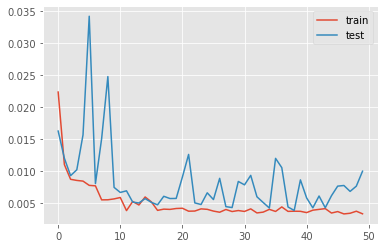

In [23]:
# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [24]:
# Get the predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [25]:
predictions

array([[129.53065],
       [128.90921],
       [133.7313 ],
       [143.30293],
       [147.26   ],
       [149.41261],
       [145.43532],
       [140.08368],
       [137.42294],
       [139.32263],
       [149.39384],
       [163.36841],
       [174.81549],
       [184.48738],
       [194.52112],
       [217.66708],
       [248.45952]], dtype=float32)

In [26]:
y_test = y_test.reshape(-1,1)
y_test = scaler.inverse_transform(y_test)
y_test

array([[140.],
       [158.],
       [153.],
       [157.],
       [190.],
       [146.],
       [138.],
       [171.],
       [191.],
       [222.],
       [195.],
       [178.],
       [211.],
       [256.],
       [353.],
       [329.],
       [305.]])

In [27]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('MAE: ' + str(round(mae, 1)))

# Calculate the root mean squarred error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test,predictions))
print('RMSE: ' + str(round(rmse, 1)))

MAE: 46.3
RMSE: 61.1


In [28]:
# Date from which on the date is displayed
display_start_date = "2020-09-16" 

# Add the difference between the valid and predicted prices
train = data[:training_data_length + 1]
valid = data[training_data_length:]

In [29]:
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["num_casos.x"], True)

In [30]:
# Zoom-in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Show the test / valid and predicted prices
valid

,num_casos.x,Difference,Predictions
fecha,,,
2020-12-14,140,-10.469345,129.530655
2020-12-15,158,-29.090790,128.909210
2020-12-16,153,-19.268707,133.731293
2020-12-17,157,-13.697067,143.302933
2020-12-18,190,-42.740005,147.259995
2020-12-19,146,3.412613,149.412613
2020-12-20,138,7.435318,145.435318
2020-12-21,171,-30.916321,140.083679
2020-12-22,191,-53.577057,137.422943


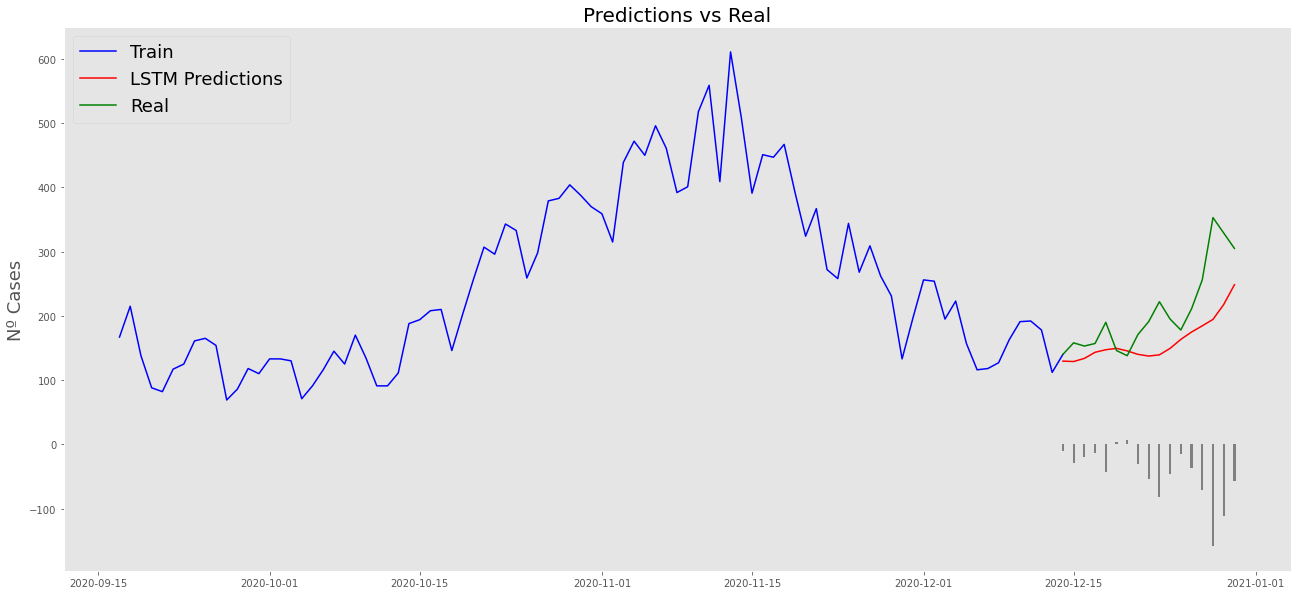

In [31]:
# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)

# Data - Train
xt = train.index; 
yt = train[["num_casos.x"]]
# Data - Test / validation 
xv = valid.index; 
yv = valid[["num_casos.x", "Predictions"]]

# Plot
plt.title("Predictions vs Real", fontsize=20)
plt.ylabel("Nº Cases", fontsize=18)

plt.plot(yt, color="blue", linewidth=1.5)
plt.plot(yv["Predictions"], color="red", linewidth=1.5)
plt.plot(yv["num_casos.x"], color="green", linewidth=1.5)
plt.legend(["Train", "LSTM Predictions", "Real"], 
           loc="upper left", fontsize=18)

# Bar plot with the differences
x = valid.index
y = valid["Difference"]
plt.bar(x, y, width=0.2, color="grey")
plt.grid()
plt.show()

## LSTM - 2 variables + infections reported

In [32]:
# New dataframe with only the 'num_casos.x' column 
# Convert it to numpy array
data_v2 = Cad.filter(['num_casos.x', 
                      'residential_percent_change_from_baseline',
                      'total'])
npdataset_v2 = data_v2.values

# Get the number of rows to train the model
# 94% of the data in order to have the same scenario like in ARIMA 
# Train 273 - Test 17
training_data_length_v2 = math.ceil(len(npdataset_v2) * 0.94)

# Transform features by scaling each feature to a range between 0 and 1
scaler_v2 = MinMaxScaler(feature_range=(0, 1))
scaled_data_v2 = scaler_v2.fit_transform(npdataset_v2)
scaled_data_v2[0:5]

array([[0.10801964, 0.58536585, 0.35585284],
       [0.08837971, 0.65853659, 0.31438127],
       [0.07692308, 0.68292683, 0.2729097 ],
       [0.09001637, 0.70731707, 0.25785953],
       [0.10638298, 0.80487805, 0.24280936]])

In [33]:
# Creating a separate scaler that works on a single column for scaling predictions
scaler_v2_pred = MinMaxScaler(feature_range=(0, 1))
df_cases = pd.DataFrame(Cad['num_casos.x'])
np_cases_scaled_v2 = scaler_v2_pred.fit_transform(df_cases)
np_cases_scaled_v2[0:5]

array([[0.10801964],
       [0.08837971],
       [0.07692308],
       [0.09001637],
       [0.10638298]])

In [34]:
# Create the training data
train_data_v2 = scaled_data_v2[0:training_data_length_v2, :]
print(train_data_v2.shape)

(273, 3)


In [35]:
train_data_v2[0:2]

array([[0.10801964, 0.58536585, 0.35585284],
       [0.08837971, 0.65853659, 0.31438127]])

In [36]:
training_data_length_v2

273

In [37]:
loop_back

14

In [38]:
x_train_v2 = []
y_train_v2 = []
# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, N loop_back time steps per sample, and 2 features (all mobility)
for i in range(loop_back, training_data_length_v2):
    #print(i)
    #contains loop_back values ->>> 0-loop_back * columsn
    x_train_v2.append(train_data_v2[i-loop_back:i,:]) 
    #contains the prediction values for test / validation
    y_train_v2.append(train_data_v2[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train_v2, y_train_v2 = np.array(x_train_v2), np.array(y_train_v2)
x_train_v2[0:2]

array([[[0.10801964, 0.58536585, 0.35585284],
        [0.08837971, 0.65853659, 0.31438127],
        [0.07692308, 0.68292683, 0.2729097 ],
        [0.09001637, 0.70731707, 0.25785953],
        [0.10638298, 0.80487805, 0.24280936],
        [0.101473  , 0.70731707, 0.12140468],
        [0.06382979, 0.6097561 , 0.        ],
        [0.08510638, 0.70731707, 0.15551839],
        [0.07692308, 0.73170732, 0.31103679],
        [0.06382979, 0.75609756, 0.32140468],
        [0.05728314, 0.75609756, 0.33177258],
        [0.04909984, 0.82926829, 0.25016722],
        [0.04909984, 0.68292683, 0.16856187],
        [0.05400982, 0.6097561 , 0.21270903]],

       [[0.08837971, 0.65853659, 0.31438127],
        [0.07692308, 0.68292683, 0.2729097 ],
        [0.09001637, 0.70731707, 0.25785953],
        [0.10638298, 0.80487805, 0.24280936],
        [0.101473  , 0.70731707, 0.12140468],
        [0.06382979, 0.6097561 , 0.        ],
        [0.08510638, 0.70731707, 0.15551839],
        [0.07692308, 0.73170732,

In [39]:
y_train_v2[0:2]

array([0.05728314, 0.03273322])

In [40]:
print(x_train_v2.shape, y_train_v2.shape)

(259, 14, 3) (259,)


In [41]:
# Create the test data
test_data_v2 = scaled_data_v2[training_data_length_v2 - loop_back:, :]
print(test_data_v2.shape)

x_test_v2 = []
y_test_v2 = []
# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, N loop_back time steps per sample, and 3 features (mobility + num_casos.x)
for i in range(loop_back, len(test_data_v2)):
    #print(i)
    #contains loop_back values ->>> 0-loop_back * columsn
    x_test_v2.append(test_data_v2[i-loop_back:i,:]) 
    #contains the prediction values for test / validation
    y_test_v2.append(test_data_v2[i, 0])

# Convert the x_train and y_train to numpy arrays
x_test_v2, y_test_v2 = np.array(x_test_v2), np.array(y_test_v2)
x_test_v2[0:2] 
#len(x_train_v2)

(31, 3)


array([[[0.3207856 , 0.26829268, 0.39487179],
        [0.41898527, 0.24390244, 0.59375697],
        [0.41571195, 0.26829268, 0.79264214],
        [0.31914894, 0.26829268, 0.67274247],
        [0.36497545, 0.36585366, 0.55284281],
        [0.25695581, 0.29268293, 0.43294314],
        [0.1898527 , 0.29268293, 0.31304348],
        [0.19312602, 0.53658537, 0.47090301],
        [0.20785597, 0.56097561, 0.62876254],
        [0.26677578, 0.24390244, 0.78662207],
        [0.31260229, 0.29268293, 0.70668896],
        [0.31423895, 0.31707317, 0.62675585],
        [0.2913257 , 0.24390244, 0.54682274],
        [0.18330606, 0.19512195, 0.46688963]],

       [[0.41898527, 0.24390244, 0.59375697],
        [0.41571195, 0.26829268, 0.79264214],
        [0.31914894, 0.26829268, 0.67274247],
        [0.36497545, 0.36585366, 0.55284281],
        [0.25695581, 0.29268293, 0.43294314],
        [0.1898527 , 0.29268293, 0.31304348],
        [0.19312602, 0.53658537, 0.47090301],
        [0.20785597, 0.56097561,

In [42]:
y_test_v2[0:2]

array([0.22913257, 0.25859247])

In [43]:
print(x_test_v2.shape, y_test_v2.shape)

(17, 14, 3) (17,)


In [44]:
# Configure the neural network model
model_v2 = Sequential()

# Model with N "loop_back" Neurons 
# Inputshape >>> loop_back Timestamps, each with x_train.shape[2] variables
n_neurons_v2 = x_train_v2.shape[1] * x_train_v2.shape[2]
print(n_neurons_v2, x_train_v2.shape[1], x_train_v2.shape[2])

model_v2.add(LSTM(n_neurons_v2, 
                  activation='relu',
                  return_sequences=True, 
                  input_shape=(x_train_v2.shape[1],
                               x_train_v2.shape[2]))) 
model_v2.add(LSTM(50, activation='relu', return_sequences=True)) 
model_v2.add(LSTM(25, activation='relu',return_sequences=False)) 
model_v2.add(Dense(5, activation='relu'))
model_v2.add(Dense(1))

# Compile the model
model_v2.compile(optimizer='adam', loss='mean_squared_error')

42 14 3


In [45]:
# Training the model
early_stop_v2 = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_v2 = model_v2.fit(x_train_v2,
                    y_train_v2,
                    batch_size=2, 
                    validation_data=(x_test_v2, y_test_v2),
                    epochs=50 
                    #callbacks=[early_stop_v2]
                         )

Epoch 1/50
130/130 [==============================] - 12s 28ms/step - loss: 0.0597 - val_loss: 0.0101
Epoch 2/50
130/130 [==============================] - 2s 15ms/step - loss: 0.0072 - val_loss: 0.0197
Epoch 3/50
130/130 [==============================] - 3s 20ms/step - loss: 0.0087 - val_loss: 0.0121
Epoch 4/50
130/130 [==============================] - 2s 16ms/step - loss: 0.0069 - val_loss: 0.0164
Epoch 5/50
130/130 [==============================] - 2s 16ms/step - loss: 0.0082 - val_loss: 0.0150
Epoch 6/50
130/130 [==============================] - 3s 20ms/step - loss: 0.0064 - val_loss: 0.0082
Epoch 7/50
130/130 [==============================] - 2s 19ms/step - loss: 0.0056 - val_loss: 0.0222
Epoch 8/50
130/130 [==============================] - 3s 20ms/step - loss: 0.0063 - val_loss: 0.0113
Epoch 9/50
130/130 [==============================] - 2s 16ms/step - loss: 0.0045 - val_loss: 0.0188
Epoch 10/50
130/130 [==============================] - 3s 20ms/step - loss: 0.0067 - val_l

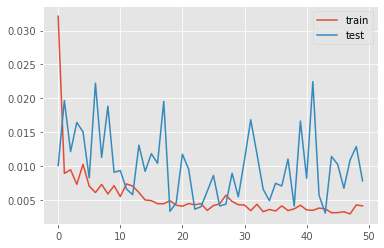

In [46]:
# Plot history
plt.plot(history_v2.history['loss'], label='train')
plt.plot(history_v2.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [47]:
# Get the predicted values
predictions_v2 = model_v2.predict(x_test_v2)
predictions_v2

array([[0.20759802],
       [0.19907223],
       [0.1973475 ],
       [0.2037837 ],
       [0.21117206],
       [0.21847494],
       [0.21711648],
       [0.21534866],
       [0.21797682],
       [0.23682909],
       [0.2690856 ],
       [0.30881923],
       [0.32450265],
       [0.33344644],
       [0.35688227],
       [0.39469033],
       [0.43910956]], dtype=float32)

In [48]:
# Get the predicted values
pred_unscaled_v2 = scaler_v2_pred.inverse_transform(predictions_v2)
y_test_v2_unscaled = scaler_v2_pred.inverse_transform(y_test_v2.reshape(-1, 1))

In [49]:
# Calculate the mean absolute error (MAE)
mae_v2 = mean_absolute_error(pred_unscaled_v2, y_test_v2_unscaled)
print('MAE: ' + str(round(mae_v2, 1)))

# Calculate the root mean squarred error (RMSE)
rmse_v2 = np.sqrt(mean_squared_error(y_test_v2_unscaled,pred_unscaled_v2))
print('RMSE: ' + str(round(rmse_v2, 1)))

MAE: 43.2
RMSE: 54.0


In [50]:
# Date from which on the date is displayed
display_start_date_v2 = "2020-09-16" 

# Add the difference between the valid and predicted prices
train_v2 = data_v2[:training_data_length_v2 + 1]
valid_v2 = data_v2[training_data_length_v2:]

In [51]:
valid_v2.insert(1, "Predictions", pred_unscaled_v2, True)
valid_v2.insert(1, "Difference", valid_v2["Predictions"] - valid_v2["num_casos.x"], True)

In [52]:
# Zoom-in to a closer timeframe
valid_v2 = valid_v2[valid_v2.index > display_start_date_v2]
train_v2 = train_v2[train_v2.index > display_start_date_v2]

# Show the test / valid and predicted prices
valid_v2

,num_casos.x,Difference,Predictions,residential_percent_change_from_baseline,total
fecha,,,,,
2020-12-14,140,-13.157616,126.842384,7.0,14.493333
2020-12-15,158,-36.366867,121.633133,5.0,16.586667
2020-12-16,153,-32.420670,120.579330,8.0,18.680000
2020-12-17,157,-32.488159,124.511841,6.0,17.247500
2020-12-18,190,-60.973877,129.026123,6.0,15.815000
2020-12-19,146,-12.511810,133.488190,7.0,14.382500
2020-12-20,138,-5.341827,132.658173,3.0,12.950000
2020-12-21,171,-39.421967,131.578033,5.0,14.680000
2020-12-22,191,-57.816162,133.183838,5.0,16.410000


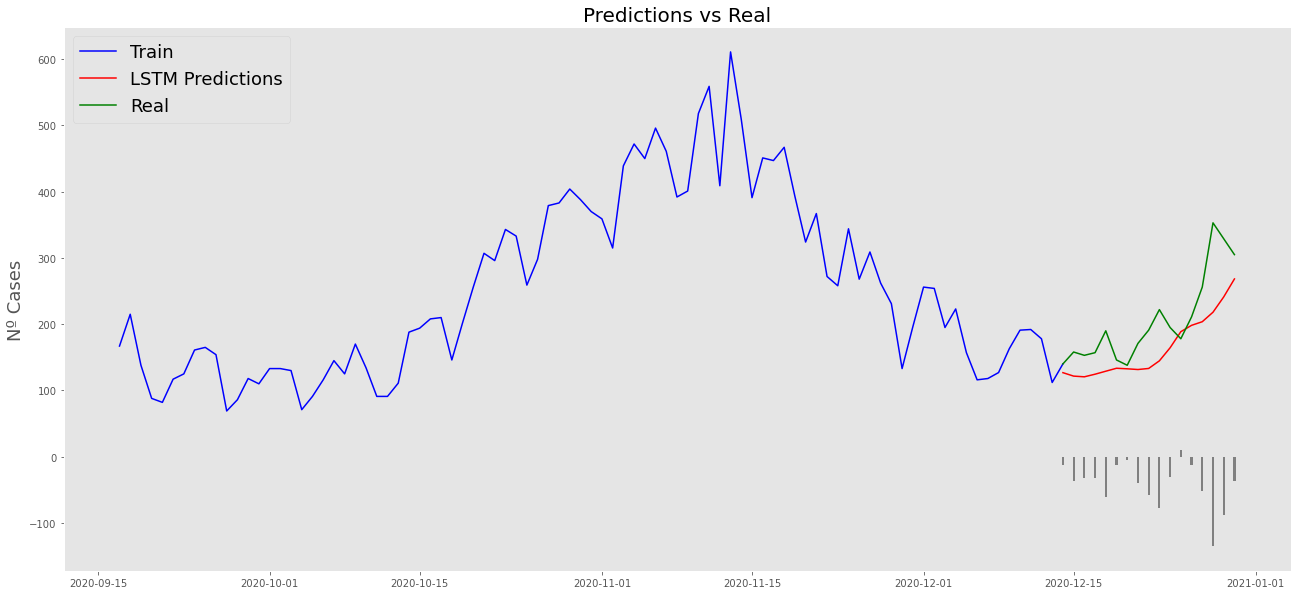

In [53]:
# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)

# Data - Train
xt_v2 = train_v2.index; 
yt_v2 = train_v2[["num_casos.x"]]
# Data - Test / validation 
xv_v2 = valid_v2.index; 
yv_v2 = valid_v2[["num_casos.x", "Predictions"]]

# Plot
plt.title("Predictions vs Real", fontsize=20)
plt.ylabel("Nº Cases", fontsize=18)

plt.plot(yt_v2, color="blue", linewidth=1.5)
plt.plot(yv_v2["Predictions"], color="red", linewidth=1.5)
plt.plot(yv_v2["num_casos.x"], color="green", linewidth=1.5)
plt.legend(["Train", "LSTM Predictions", "Real"], 
           loc="upper left", fontsize=18)

# Bar plot with the differences
x_v2 = valid_v2.index
y_v2 = valid_v2["Difference"]
plt.bar(x_v2, y_v2, width=0.2, color="grey")
plt.grid()
plt.show()

## LSTM - All variables

In [54]:
# New dataframe with only the 'num_casos.x' column 
# Convert it to numpy array
data_v3 = Cad.filter(['num_casos.x', 
                      'residential_percent_change_from_baseline',     
                      'retail_and_recreation_percent_change_from_baseline',
                      'grocery_and_pharmacy_percent_change_from_baseline',
                      'parks_percent_change_from_baseline',
                      'transit_stations_percent_change_from_baseline',
                      'workplaces_percent_change_from_baseline',
                      'total'])
npdataset_v3 = data_v3.values

# Get the number of rows to train the model
# 94% of the data in order to have the same scenario like in ARIMA 
# Train 273 - Test 17
training_data_length_v3 = math.ceil(len(npdataset_v3) * 0.94)

# Transform features by scaling each feature to a range between 0 and 1
scaler_v3 = MinMaxScaler(feature_range=(0, 1))
scaled_data_v3 = scaler_v3.fit_transform(npdataset_v3)
scaled_data_v3[0:5]

array([[0.10801964, 0.58536585, 0.13076923, 0.32      , 0.0701107 ,
        0.26804124, 0.32075472, 0.35585284],
       [0.08837971, 0.65853659, 0.08461538, 0.22857143, 0.04797048,
        0.19587629, 0.23584906, 0.31438127],
       [0.07692308, 0.68292683, 0.08461538, 0.24      , 0.04797048,
        0.15463918, 0.22641509, 0.2729097 ],
       [0.09001637, 0.70731707, 0.08461538, 0.24      , 0.04797048,
        0.16494845, 0.19811321, 0.25785953],
       [0.10638298, 0.80487805, 0.06923077, 0.22857143, 0.03690037,
        0.11340206, 0.19811321, 0.24280936]])

In [55]:
# Creating a separate scaler that works on a single column for scaling predictions
scaler_v3_pred = MinMaxScaler(feature_range=(0, 1))
df_cases = pd.DataFrame(Cad['num_casos.x'])
np_cases_scaled_v3 = scaler_v3_pred.fit_transform(df_cases)
np_cases_scaled_v3[0:5]

array([[0.10801964],
       [0.08837971],
       [0.07692308],
       [0.09001637],
       [0.10638298]])

In [56]:
# Create the training data
train_data_v3 = scaled_data_v3[0:training_data_length_v3, :]
print(train_data_v3.shape)

(273, 8)


In [57]:
train_data_v3[0:2]

array([[0.10801964, 0.58536585, 0.13076923, 0.32      , 0.0701107 ,
        0.26804124, 0.32075472, 0.35585284],
       [0.08837971, 0.65853659, 0.08461538, 0.22857143, 0.04797048,
        0.19587629, 0.23584906, 0.31438127]])

In [58]:
training_data_length_v3

273

In [59]:
x_train_v3 = []
y_train_v3 = []
# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, N loop_back time steps per sample, and 8 features (all)
for i in range(loop_back, training_data_length_v3):
    #print(i)
    #contains loop_back values ->>> 0-loop_back * columsn
    x_train_v3.append(train_data_v3[i-loop_back:i,:]) 
    #contains the prediction values for test / validation
    y_train_v3.append(train_data_v3[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train_v3, y_train_v3 = np.array(x_train_v3), np.array(y_train_v3)
x_train_v3[0:2]

array([[[0.10801964, 0.58536585, 0.13076923, 0.32      , 0.0701107 ,
         0.26804124, 0.32075472, 0.35585284],
        [0.08837971, 0.65853659, 0.08461538, 0.22857143, 0.04797048,
         0.19587629, 0.23584906, 0.31438127],
        [0.07692308, 0.68292683, 0.08461538, 0.24      , 0.04797048,
         0.15463918, 0.22641509, 0.2729097 ],
        [0.09001637, 0.70731707, 0.08461538, 0.24      , 0.04797048,
         0.16494845, 0.19811321, 0.25785953],
        [0.10638298, 0.80487805, 0.06923077, 0.22857143, 0.03690037,
         0.11340206, 0.19811321, 0.24280936],
        [0.101473  , 0.70731707, 0.03846154, 0.17142857, 0.01107011,
         0.09278351, 0.20754717, 0.12140468],
        [0.06382979, 0.6097561 , 0.01538462, 0.07428571, 0.        ,
         0.06185567, 0.18867925, 0.        ],
        [0.08510638, 0.70731707, 0.09230769, 0.23428571, 0.04428044,
         0.13402062, 0.17924528, 0.15551839],
        [0.07692308, 0.73170732, 0.06923077, 0.18857143, 0.03690037,
         0.

In [60]:
y_train_v3[0:2]

array([0.05728314, 0.03273322])

In [61]:
print(x_train_v3.shape, y_train_v3.shape)

(259, 14, 8) (259,)


In [62]:
# Create the test data
test_data_v3 = scaled_data_v3[training_data_length_v3 - loop_back:, :]
print(test_data_v3.shape)

x_test_v3 = []
y_test_v3 = []
# The RNN needs data with the format of [samples, time steps, features].
# Here, we create N samples, N loop_back time steps per sample, and 3 features (mobility + num_casos.x)
for i in range(loop_back, len(test_data_v3)):
    #print(i)
    #contains loop_back values ->>> 0-loop_back * columsn
    x_test_v3.append(test_data_v3[i-loop_back:i,:]) 
    #contains the prediction values for test / validation
    y_test_v3.append(test_data_v3[i, 0])

# Convert the x_train and y_train to numpy arrays
x_test_v3, y_test_v3 = np.array(x_test_v3), np.array(y_test_v3)
x_test_v3[0:2] 
#len(x_train_v3)

(31, 8)


array([[[0.3207856 , 0.26829268, 0.53076923, 0.50857143, 0.24723247,
         0.60824742, 0.67924528, 0.39487179],
        [0.41898527, 0.24390244, 0.54615385, 0.52      , 0.28782288,
         0.6185567 , 0.68867925, 0.59375697],
        [0.41571195, 0.26829268, 0.54615385, 0.53714286, 0.28413284,
         0.6185567 , 0.69811321, 0.79264214],
        [0.31914894, 0.26829268, 0.54615385, 0.53714286, 0.26937269,
         0.62886598, 0.67924528, 0.67274247],
        [0.36497545, 0.36585366, 0.44615385, 0.49142857, 0.15867159,
         0.5257732 , 0.6509434 , 0.55284281],
        [0.25695581, 0.29268293, 0.48461538, 0.54285714, 0.23616236,
         0.54639175, 0.72641509, 0.43294314],
        [0.1898527 , 0.29268293, 0.44615385, 0.58857143, 0.22140221,
         0.42268041, 0.68867925, 0.31304348],
        [0.19312602, 0.53658537, 0.48461538, 0.45714286, 0.18819188,
         0.32989691, 0.22641509, 0.47090301],
        [0.20785597, 0.56097561, 0.42307692, 0.28571429, 0.19926199,
         0.

In [63]:
y_test_v3[0:2]

array([0.22913257, 0.25859247])

In [64]:
print(x_test_v3.shape, y_test_v3.shape)

(17, 14, 8) (17,)


In [65]:
# Configure the neural network model
model_v3 = Sequential()

# Model with N "loop_back" Neurons 
# Inputshape >>> loop_back Timestamps, each with x_train.shape[2] variables
n_neurons_v3 = x_train_v3.shape[1] * x_train_v3.shape[2]
print(n_neurons_v3, x_train_v3.shape[1], x_train_v3.shape[2])

model_v3.add(LSTM(n_neurons_v3, 
                  activation='relu',
                  return_sequences=True, 
                  input_shape=(x_train_v3.shape[1],
                               x_train_v3.shape[2]))) 
model_v3.add(LSTM(50, activation='relu', return_sequences=True)) 
model_v3.add(LSTM(25, activation='relu',return_sequences=False)) 
model_v3.add(Dense(5, activation='relu'))
model_v3.add(Dense(1))

# Compile the model
model_v3.compile(optimizer='adam', loss='mean_squared_error')

112 14 8


In [66]:
# Training the model
early_stop_v3 = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_v3 = model_v3.fit(x_train_v3,
                    y_train_v3,
                    batch_size=2, 
                    validation_data=(x_test_v3, y_test_v3),
                    epochs=50 
                    #callbacks=[early_stop_v2]
                         )

Epoch 1/50
130/130 [==============================] - 10s 27ms/step - loss: 0.0482 - val_loss: 0.0319
Epoch 2/50
130/130 [==============================] - 3s 19ms/step - loss: 0.0120 - val_loss: 0.0080
Epoch 3/50
130/130 [==============================] - 2s 18ms/step - loss: 0.0108 - val_loss: 0.0125
Epoch 4/50
130/130 [==============================] - 3s 22ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 5/50
130/130 [==============================] - 2s 18ms/step - loss: 0.0066 - val_loss: 0.0251
Epoch 6/50
130/130 [==============================] - 3s 21ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 7/50
130/130 [==============================] - 3s 20ms/step - loss: 0.0063 - val_loss: 0.0153
Epoch 8/50
130/130 [==============================] - 3s 23ms/step - loss: 0.0063 - val_loss: 0.0134
Epoch 9/50
130/130 [==============================] - 2s 17ms/step - loss: 0.0063 - val_loss: 0.0125
Epoch 10/50
130/130 [==============================] - 3s 22ms/step - loss: 0.0062 - val_l

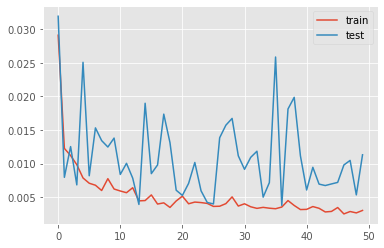

In [67]:
# Plot history
plt.plot(history_v3.history['loss'], label='train')
plt.plot(history_v3.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [68]:
# Get the predicted values
predictions_v3 = model_v3.predict(x_test_v3)
predictions_v3

array([[0.18996866],
       [0.1951589 ],
       [0.21025515],
       [0.23140553],
       [0.25299728],
       [0.24498552],
       [0.21799392],
       [0.19986223],
       [0.20329835],
       [0.22916168],
       [0.2721959 ],
       [0.3055893 ],
       [0.30865157],
       [0.2799372 ],
       [0.2922846 ],
       [0.34919062],
       [0.4340176 ]], dtype=float32)

In [69]:
# Get the predicted values
pred_unscaled_v3 = scaler_v3_pred.inverse_transform(predictions_v3)
y_test_v3_unscaled = scaler_v3_pred.inverse_transform(y_test_v3.reshape(-1, 1))

In [70]:
# Calculate the mean absolute error (MAE)
mae_v3 = mean_absolute_error(pred_unscaled_v3, y_test_v3_unscaled)
print('MAE: ' + str(round(mae_v3, 1)))

# Calculate the root mean squarred error (RMSE)
rmse_v3 = np.sqrt(mean_squared_error(y_test_v3_unscaled,pred_unscaled_v3))
print('RMSE: ' + str(round(rmse_v3, 1)))

MAE: 48.2
RMSE: 65.0


In [71]:
# Date from which on the date is displayed
display_start_date_v3 = "2020-09-16" 

# Add the difference between the valid and predicted prices
train_v3 = data_v3[:training_data_length_v3 + 1]
valid_v3 = data_v3[training_data_length_v3:]

In [72]:
valid_v3.insert(1, "Predictions", pred_unscaled_v3, True)
valid_v3.insert(1, "Difference", valid_v3["Predictions"] - valid_v3["num_casos.x"], True)

In [73]:
# Zoom-in to a closer timeframe
valid_v3 = valid_v3[valid_v3.index > display_start_date_v3]
train_v3 = train_v3[train_v3.index > display_start_date_v3]

# Show the test / valid and predicted prices
valid_v3

,num_casos.x,Difference,Predictions,residential_percent_change_from_baseline,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,total
fecha,,,,,,,,,,
2020-12-14,140,-23.929146,116.070854,7.0,-21.0,-4.0,-34.0,-32.0,-14.0,14.493333
2020-12-15,158,-38.757912,119.242088,5.0,-15.0,4.0,-10.0,-28.0,-13.0,16.586667
2020-12-16,153,-24.534103,128.465897,8.0,-27.0,-4.0,-40.0,-37.0,-15.0,18.680000
2020-12-17,157,-15.611221,141.388779,6.0,-17.0,8.0,-14.0,-28.0,-14.0,17.247500
2020-12-18,190,-35.418655,154.581345,6.0,-19.0,4.0,-6.0,-26.0,-12.0,15.815000
2020-12-19,146,3.686157,149.686157,7.0,-29.0,-2.0,-34.0,-34.0,-10.0,14.382500
2020-12-20,138,-4.805725,133.194275,3.0,-13.0,83.0,-16.0,-33.0,-3.0,12.950000
2020-12-21,171,-48.884178,122.115822,5.0,-5.0,13.0,-5.0,-24.0,-17.0,14.680000
2020-12-22,191,-66.784714,124.215286,5.0,-6.0,17.0,-3.0,-26.0,-19.0,16.410000


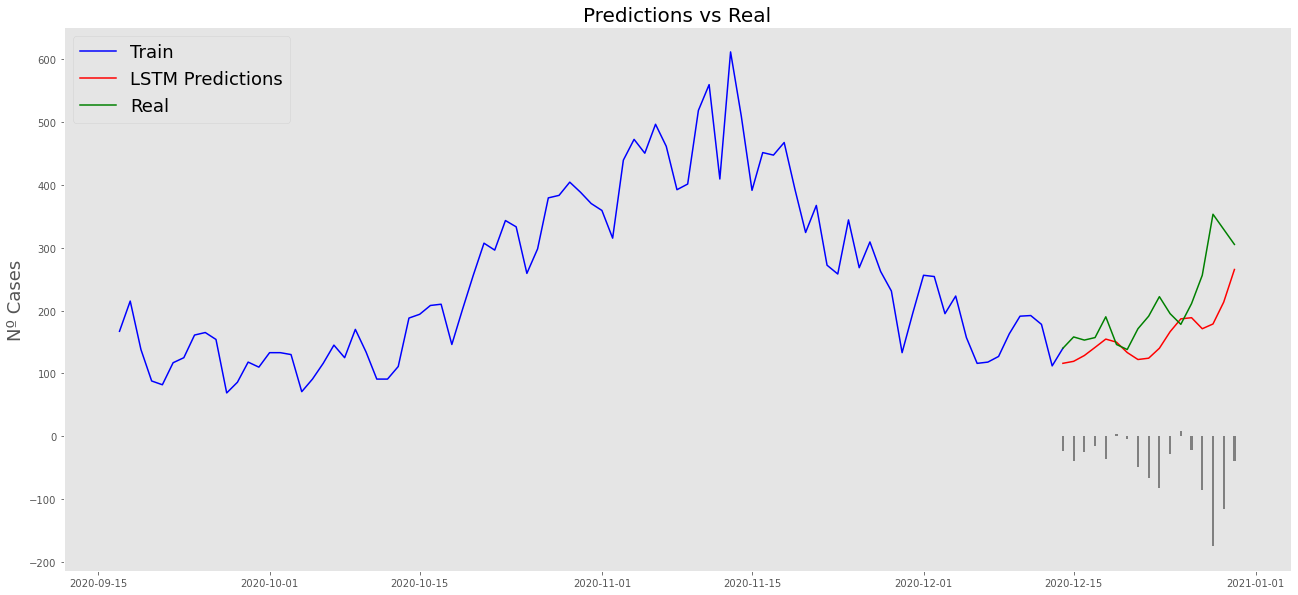

In [74]:
# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)

# Data - Train
xt_v3 = train_v3.index; 
yt_v3 = train_v3[["num_casos.x"]]
# Data - Test / validation 
xv_v3 = valid_v3.index; 
yv_v3 = valid_v3[["num_casos.x", "Predictions"]]

# Plot
plt.title("Predictions vs Real", fontsize=20)
plt.ylabel("Nº Cases", fontsize=18)

plt.plot(yt_v3, color="blue", linewidth=1.5)
plt.plot(yv_v3["Predictions"], color="red", linewidth=1.5)
plt.plot(yv_v3["num_casos.x"], color="green", linewidth=1.5)
plt.legend(["Train", "LSTM Predictions", "Real"], 
           loc="upper left", fontsize=18)

# Bar plot with the differences
x_v3 = valid_v3.index
y_v3 = valid_v3["Difference"]
plt.bar(x_v3, y_v3, width=0.2, color="grey")
plt.grid()
plt.show()